# Development of dataloaders
Scratch notebook - do not use for prod!

In [1]:
# PyTorch, Torchvision
import torch
from torch import nn
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
from torchvision.io import write_video

# Common
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from IPython.display import Video

# Utils from Torchvision
tensor_to_image = ToPILImage()
image_to_tensor = ToTensor()

In [3]:
def get_img_dict(img_dir):
    img_files = [x for x in img_dir.iterdir() if x.name.endswith('.png') or x.name.endswith('.tiff')]
    img_files.sort()

    img_dict = {}
    for img_file in img_files:
        img_type = img_file.name.split('_')[0]
        if img_type not in img_dict:
            img_dict[img_type] = []
        img_dict[img_type].append(img_file)
    return img_dict

In [4]:
def get_sample_dict(sample_dir):

    camera_dirs = [x for x in sample_dir.iterdir() if 'camera' in x.name]
    camera_dirs.sort()
    
    sample_dict = {}

    for cam_dir in camera_dirs:
        cam_dict = {}
        cam_dict['scene'] = get_img_dict(cam_dir)

        obj_dirs = [x for x in cam_dir.iterdir() if 'obj_' in x.name]
        obj_dirs.sort()
        
        for obj_dir in obj_dirs:
            cam_dict[obj_dir.name] = get_img_dict(obj_dir)

        sample_dict[cam_dir.name] = cam_dict

    return sample_dict

In [5]:
def make_obj_viz(cam_dict, cam_num=0):

    n_frames = 24
    n_cols = 6

    all_obj_ids = [x for x in sample_dict['camera_0000'].keys() if 'obj_' in x]
    obj_id_str = random.sample(all_obj_ids, k=1)[0]
    obj_id_int = int(obj_id_str.split('_')[1])

    grid_tensors = []
    for i in range(n_frames):
        grid = []
        scene_rgb_tensor = image_to_tensor(Image.open(cam_dict['scene']['rgba'][i]).convert('RGB'))
        grid.append(scene_rgb_tensor)
        scene_masks_tensor = image_to_tensor(Image.open(cam_dict['scene']['segmentation'][i]).convert('RGB'))
        grid.append(scene_masks_tensor)

        scene_masks_p = Image.open(cam_dict['scene']['segmentation'][i])
        scene_masks_p_tensor = torch.tensor(np.array(scene_masks_p))
        obj_modal_tensor = (scene_masks_p_tensor==obj_id_int)
        blended_obj_modal_tensor = scene_masks_tensor*obj_modal_tensor
        grid.append(blended_obj_modal_tensor)

        obj_amodal_tensor = image_to_tensor(Image.open(cam_dict[obj_id_str]['segmentation'][i]).convert('RGB'))
        blended_obj_amodal_tensor = blended_obj_modal_tensor + (obj_amodal_tensor != obj_modal_tensor)
        grid.append(blended_obj_amodal_tensor)

        obj_rgb_tensor = image_to_tensor(Image.open(cam_dict[obj_id_str]['rgba'][i]).convert('RGB'))
        grid.append(obj_rgb_tensor)

        blended_scene_obj_tensor = (scene_rgb_tensor/3 + 2*blended_obj_amodal_tensor/3)
        grid.append(blended_scene_obj_tensor)
            
        grid_tensors.append(make_grid(grid, nrow=n_cols, padding=2, pad_value=127))
            
    return grid_tensors

In [6]:
def make_vid(grid_tensors, save_path):
    vid_tensor = torch.stack(grid_tensors, dim=1).permute(1, 2, 3, 0)
    vid_tensor = (vid_tensor*255).long()
    write_video(save_path, vid_tensor, fps=5, options={'crf':'20'})

In [7]:
def make_vid(grid_tensors, save_path):
    vid_tensor = torch.stack(grid_tensors, dim=1).permute(1, 2, 3, 0)
    vid_tensor = (vid_tensor*255).long()
    write_video(save_path, vid_tensor, fps=5, options={'crf':'20'})

In [ ]:
from torch.utils.data import Dataset
from pathlib import Path

# Define base class that contains the loading and formatting of dictionaries
class MultiDirDatasetBase(Dataset):
    def __init__(self, sample_dirs, num_frames=24, num_cams=6):
        if isinstance(sample_dirs, str) or isinstance(sample_dirs, Path):
            sample_dirs = [sample_dirs]
        self.sample_dirs = [Path(d) for d in sample_dirs]
        self.num_frames = num_frames
        self.num_cams = num_cams

        # Build a list of (sample_dict_idx, cam_idx, frame_idx) tuples
        self.index_list = []
        self.sample_dicts = []
        for sample_dir in self.sample_dirs:
            sample_dict = get_sample_dict(sample_dir)
            self.sample_dicts.append(sample_dict)
            for cam_idx in range(self.num_cams):
                for frame_idx in range(self.num_frames):
                    # Create index list to keep track
                    self.index_list.append((len(self.sample_dicts)-1, cam_idx, frame_idx))

    def __len__(self):
        return len(self.index_list)

    # __getitem__ is intentionally not implemented here
    # so that child classes must define their own version
    
# Child class: for simple dataset for Example Baseline experiment
class BaselineMultiDirDataset(MultiDirDatasetBase):
    def __getitem__(self, idx):
        sample_dict_idx, cam_idx, frame_idx = self.index_list[idx]
        sample_dict = self.sample_dicts[sample_dict_idx]

        scene_img = Image.open(
            sample_dict[f'camera_{cam_idx:04d}']['scene']['rgba'][frame_idx]
        ).convert('RGB')
        obj_masks = Image.open(
            sample_dict[f'camera_{cam_idx:04d}']['scene']['segmentation'][frame_idx]
        )
        # convert the RGB view of the scene into a tensor
        scene = image_to_tensor(scene_img)
        # Create a mask that is 1 where there is an object
        mask = (torch.tensor(np.array(obj_masks)) != 0).float()

        return scene, mask

In [8]:
N_SAMPLES_DOWNLOADED_TRAIN = 170
N_SAMPLES_DOWNLOADED_TEST = 39
N_TOT_FRAMES = 24

In [ ]:
# From the provided material
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
import torch
from PIL import Image
import numpy as np
import random

# Current prod dataloader
# This will correctly apply the modal_mask filtering to get a single object
class MOVi_Dataset(Dataset):
    def __init__(self, 
                 root,
                 split = 'train' or 'test', 
                 n_frames = 8,
                 n_samples = 1000,
                 #box_format = 'xywh'
                 ):
        """
        Initialize the MOVi dataset loader.
        This dataloader picks a random scene (video sample), a random object, and a random camera view.
        It will then load all frames from the chosen video and camera view, for its chosen object.
        
        Args:
            root: The root folder that holds the unzipped sample folders
            split: Which root subfolder to draw from (train or test)
            n_frames: How many consecutive frames to load
            n_samples: How many samples to load. This is equal to the number of objects you want to load.
            
        The dataset returned will be in the form of a dictionary, containing keys:
        'frames': RGB content, tensor with 3 channels, depth = n_frames (consecutive frames)
        'depths': modal depths, tensor, binary single channel
        'modal_masks': modal masks (occluded), binary single channel 
        'amodal_masks': amodal masks, binary single channel
        'amodal_content': RGB content, tensor with 3 channels
        'metadata': A metadata dictionary, offering info on scene, camera, object ID, as well as the number of objects in the scene.
            
        """
        print('Dataset init on', split)

        self.split = split
        self.top_dir = f'{root}/{split}/'
        print('Init data top dir:', self.top_dir)

        #self.box_format = box_format

        # Get directories in data_dir/train-test
        self.scenes = [entry for entry in os.listdir(self.top_dir) if os.path.isdir(os.path.join(self.top_dir, entry))]
        
        assert n_frames <= N_TOT_FRAMES
        self.n_frames = n_frames
        self.n_samples = n_samples

    def __len__(self):
        # In theory this could be like n_scenes*n_objects
        # To get total number of (cam-invariant) objects
        return self.n_samples

    def load_cam_frames(self, scene, 
                    cam_idx,
                    start, stop, 
                    modality):
        """
        One load-frames loads camera-level stuff (rgb, depth)
        The other one loads object-level stuff (scene/cam/obj_i/amodal_mask or content)
        """
        # Load frame range
        imgs = []
        suffix = '.png'

        totensor = ToTensor()

        for i in range(start, stop):
            # loads train/scene_id/cam_id/frames_or_depth_or_modal/frame_id.png
            if modality == 'modal_masks':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/segmentation_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file))
            
            if modality == 'rgba_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB')) # RGB, 3 chans

            if modality == 'depth_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/depth_{str(i).zfill(5)}.tiff'
                tens = totensor(Image.open(load_file).convert('RGB')) # RGB, 3 chans
                
            tens = totensor(Image.open(load_file))
            imgs.append(tens)

        tensor = torch.stack(imgs, dim = 1)

        return tensor
    
    def load_obj_frames(self, scene, 
                    cam_idx,
                    object_idx,
                    start, stop, 
                    modality):
        """
        This loaded loads object-level stuff
        """
        # Load frame range
        imgs = []
        # amodal_segs, content, rgba_full, modal_masks, depth_full
        suffix = '.png'

        totensor = ToTensor()

        for i in range(start, stop):
            if modality == 'amodal_segs':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/segmentation_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file))

            if modality == 'content':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB'))
                
            if modality == 'depth_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB'))
            imgs.append(tens)

        tensor = torch.stack(imgs, dim = 1)
        return tensor


    def __getitem__(self, idx):
        # Select a random sample
        random_scene = np.random.choice(self.scenes)

        # Get the list of objects in that sample
        all_object_ids = self.all_objects(self.top_dir + random_scene + '/camera_0000/' )
        
        # Pick a random object 
        target_object_id = np.random.choice(all_object_ids)

        """
        Loading from multiple cameras in parallel:
        """

        # Make these random
        start = random.randint(0, 24-self.n_frames) # pick random integer between 0 and 24-n_frames 
        stop = start+self.n_frames # end at 

        i = random.randint(0, 5) # pick a random camera
        cam_id = f'camera_{str(i).zfill(4)}'
        frames, depths, modal_masks, amodal_segs, amodal_content = self.load_camera(random_scene, cam_id = cam_id, 
                                                                                    obj_id = target_object_id, start = start, stop = stop)
        
        # Inflate modal masks to 255
        # No need - already done in load camera!!
        # modal_masks = modal_masks*255
        # modal_masks = modal_masks.to(torch.uint8)
        obj_id_int = int(str(target_object_id).split(sep="_")[-1]) # get integer obj ID
        modal_masks = (modal_masks == obj_id_int).int() # filter into a binary modal mask for the object
        # this is one object, all frames
        # Add tracking info to the single sample
        sample = {
            'frames': frames,
            'depths': depths,
            'modal_masks': modal_masks,
            'amodal_masks': amodal_segs,
            'amodal_content': amodal_content,
            'metadata': {'scene': str(random_scene),
                         'cam_id': cam_id,
                         'obj_id': str(target_object_id),
                         'n_tot_objects_in_scene': len(all_object_ids)}
        }
        return sample

    
    def load_camera(self, scene_id, cam_id, obj_id, start, stop):

        # Load the target objects 
        modal_segs = self.load_cam_frames(scene_id, 
                                            cam_id,
                                            start, stop,
                                            'modal_masks')
        
        # Inflate modal_segs from float to integers
        # Should give one integer in range(0, Nobj-1)
        modal_segs = modal_segs*255
        modal_segs = modal_segs.int()

        # Load frames corresponding to inputs
        frames = self.load_cam_frames(scene_id, 
                                      cam_id, 
                                      start, 
                                      stop, 
                                      'rgba_full')[:-1] #drop the A 

        # Load depth (though we will have to replace with Depth-Anything-V2 estimates)
        depths = self.load_cam_frames(scene_id, cam_id, start, stop, 'depth_full')

        amodal_segs = self.load_obj_frames(scene_id, cam_id, obj_id, start, stop, 'amodal_segs')
        amodal_content = self.load_obj_frames(scene_id, cam_id, obj_id, start, stop, 'content')
        
        return frames, depths, modal_segs, amodal_segs, amodal_content
    
    def all_objects(self, pth):
        """
        Given a path, get the objects at that path using regex
        """
        #print('looking for all objects at', pth)
        
        # Find all matches
        matches = []
        for fname in sorted(os.listdir(pth)):
            if 'obj_' in fname:
                matches.append(fname)

        #print(matches)
        return matches # list of ['obj_0001', 'obj_0009',...]

In [91]:
ROOT_PATH = "/p/lustre2/marcou1/dsc2025/dsc25_data"
ROOT_PATH = "/Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data"


In [92]:
movi_ds = MOVi_Dataset(root=ROOT_PATH, split = 'test', n_frames = 8, n_samples=30)

Dataset init on test
Init data top dir: /Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data/test/


In [111]:
sample = next(iter(movi_ds))
print('frame', sample['frames'].shape) # 3 chans, 8 frames, 256x256 pixels
print('depth', sample['depths'].shape) # 1 chans (float), 8 frames, 256x256 pixels
print('mmasks',sample['modal_masks'].shape, sample['modal_masks'].dtype) # 1 chans, 8 frames, 256x256 pixels (int)
print(sample['amodal_masks'].shape, sample['modal_masks'].dtype) # 1 chans, 8 frames, 256x256 pixels (int)
print(sample['amodal_content'].shape, sample['amodal_content'].dtype) # 3 chans (float), 8 frames, 256x256 pixels (int)

sample

frame torch.Size([3, 8, 256, 256])
depth torch.Size([1, 8, 256, 256])
mmasks torch.Size([1, 8, 256, 256]) torch.int32
torch.Size([1, 8, 256, 256]) torch.int32
torch.Size([3, 8, 256, 256]) torch.float32


{'frames': tensor([[[[0.5569, 0.5765, 0.5725,  ..., 0.3882, 0.3882, 0.3843],
           [0.5098, 0.5059, 0.4784,  ..., 0.3843, 0.3725, 0.3725],
           [0.3373, 0.3176, 0.2784,  ..., 0.3765, 0.3647, 0.3725],
           ...,
           [0.3647, 0.3647, 0.3569,  ..., 0.3333, 0.3451, 0.3333],
           [0.3647, 0.3569, 0.3451,  ..., 0.3412, 0.3529, 0.3490],
           [0.3608, 0.3451, 0.3294,  ..., 0.3412, 0.3529, 0.3608]],
 
          [[0.5922, 0.6118, 0.6039,  ..., 0.3961, 0.4000, 0.3961],
           [0.6000, 0.5961, 0.5882,  ..., 0.3882, 0.3843, 0.3804],
           [0.5961, 0.5765, 0.5569,  ..., 0.3804, 0.3804, 0.3804],
           ...,
           [0.3608, 0.3608, 0.3569,  ..., 0.3569, 0.3686, 0.3529],
           [0.3608, 0.3569, 0.3490,  ..., 0.3529, 0.3647, 0.3608],
           [0.3608, 0.3529, 0.3333,  ..., 0.3373, 0.3569, 0.3647]],
 
          [[0.6000, 0.6118, 0.6039,  ..., 0.3922, 0.4000, 0.3961],
           [0.6000, 0.6000, 0.5961,  ..., 0.3765, 0.3804, 0.3843],
           [0.

tensor(5.6159) tensor(23.7340)


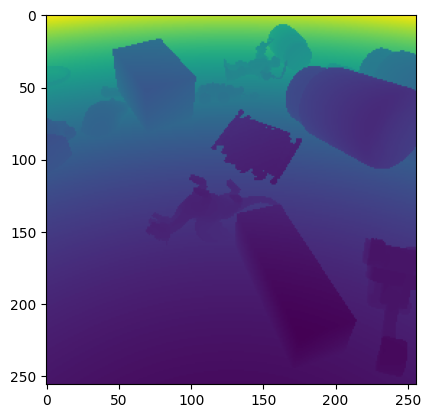

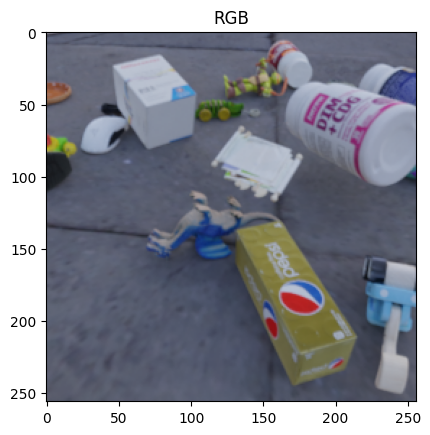

tensor(0, dtype=torch.int32) tensor(1, dtype=torch.int32)


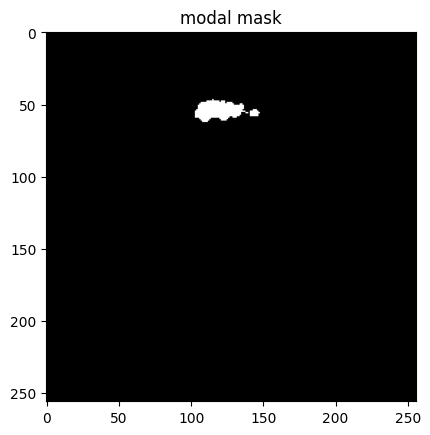

tensor(0.) tensor(1.)


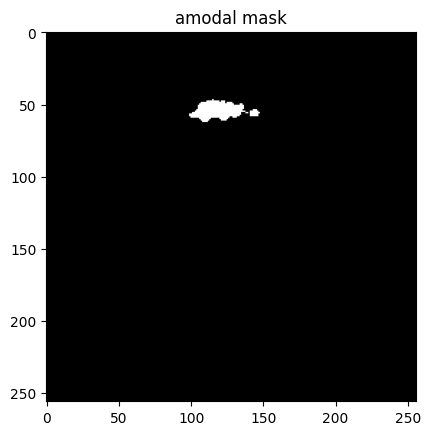

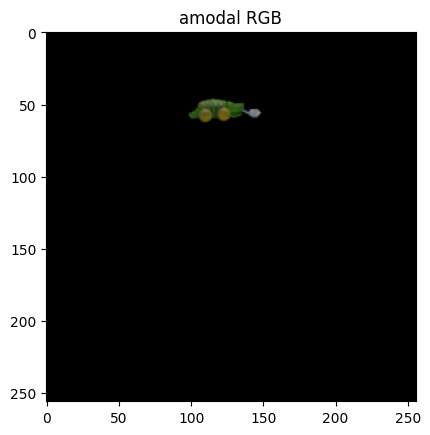

In [112]:
import matplotlib.pyplot as plt

dep = sample['depths'][0][0]
print(dep.min(), dep.max())
plt.imshow(dep)
plt.show()

rgb = sample['frames'][:, 0].permute(1,2,0)
plt.imshow(rgb)
plt.title("RGB")
plt.show()

mmask = sample['modal_masks'][:, 0].permute(1,2,0)
print(mmask.min(), mmask.max())
plt.imshow(mmask, cmap='gray')
plt.title("modal mask")
plt.show()

amask = sample['amodal_masks'][:, 0].permute(1,2,0)
print(amask.min(), amask.max())
plt.imshow(amask, cmap='gray')
plt.title("amodal mask")
plt.show()

plt.imshow(sample['amodal_content'][:, 0].permute(1,2,0))
plt.title("amodal RGB")
plt.show()

In [98]:
modal_mask = sample['modal_masks']
np.unique(modal_mask)

array([0, 1], dtype=int32)

In [56]:
mmask.shape

torch.Size([256, 256, 1])

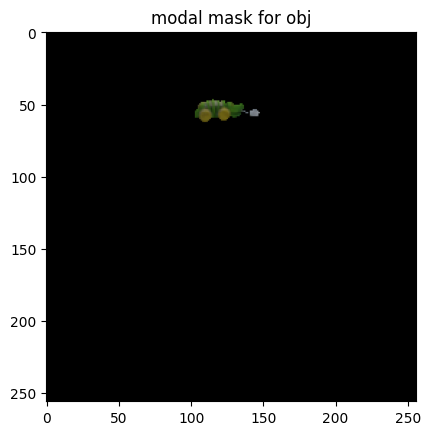

In [113]:
plt.imshow(sample['amodal_content'][:, 0].permute(1,2,0))
plt.imshow(sample['amodal_content'][:, 0].permute(1,2,0) * mmask)
plt.title("modal mask for obj")
plt.show()

In [117]:
# Making minimal changes
# Inherit from the MOViDataset class
# pass the movi dataset (collection of many frames)
# and blow it up into a Dataset which has the tensor for each frame
class MOVi_ImageDataset(MOVi_Dataset):
    def __init__(self, n_cameras=6,nframe_sample=24,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.frame_indices = []
        # Build a list of (scene, camera, object, frame_idx) for all frames
        for scene in self.scenes:
            for cam_id in [f'camera_{str(i).zfill(4)}' for i in range(n_cameras)]:  # assuming 6 cameras
                obj_path = os.path.join(self.top_dir, scene, cam_id)
                if not os.path.exists(obj_path):
                    continue
                object_ids = self.all_objects(obj_path)
                for obj_id in object_ids:
                    # Assume all videos have 24 frames (0..24)
                    for frame_idx in range(nframe_sample):  # or use dynamic length if needed
                        self.frame_indices.append((scene, cam_id, obj_id, frame_idx))
    
    def __len__(self):
        return len(self.frame_indices)
    
    def __getitem__(self, idx):
        scene, cam_id, obj_id, frame_idx = self.frame_indices[idx]
        # Load a single frame for each modality
        frame = self.load_cam_frames(scene, cam_id, frame_idx, frame_idx+1, 'rgba_full').squeeze(1)[:-1] # ensure we get RGB 
        depth = self.load_cam_frames(scene, cam_id, frame_idx, frame_idx+1, 'depth_full').squeeze(1)
        modal_mask = self.load_cam_frames(scene, cam_id, frame_idx, frame_idx+1, 'modal_masks').squeeze(1)
        amodal_mask = self.load_obj_frames(scene, cam_id, obj_id, frame_idx, frame_idx+1, 'amodal_segs').squeeze(1)
        amodal_content = self.load_obj_frames(scene, cam_id, obj_id, frame_idx, frame_idx+1, 'content').squeeze(1)
        
        modal_mask = (modal_mask * 255).to(torch.uint8)
        
        sample = {
            'frame': frame,
            'depth': depth,
            'modal_mask': modal_mask,
            'amodal_mask': amodal_mask,
            'amodal_content': amodal_content,
            'scene': scene,
            'cam_id': cam_id,
            'obj_id': obj_id,
            'frame_idx': frame_idx
        }
        return sample

In [118]:
image_ds = MOVi_ImageDataset(root=ROOT_PATH, split = 'test', n_frames = 8, n_samples=30)

Dataset init on test
Init data top dir: /p/lustre2/marcou1/dsc2025/dsc25_data/test/


In [119]:
sample = next(iter(image_ds))
print(sample['frame'].shape)
sample

torch.Size([3, 256, 256])


{'frame': tensor([[[0.4196, 0.4118, 0.3961,  ..., 0.4314, 0.3608, 0.3216],
          [0.4078, 0.4118, 0.3647,  ..., 0.3373, 0.3373, 0.3490],
          [0.4353, 0.4157, 0.4235,  ..., 0.3412, 0.3294, 0.3529],
          ...,
          [0.2392, 0.2471, 0.2549,  ..., 0.1412, 0.1451, 0.1412],
          [0.2392, 0.2510, 0.2510,  ..., 0.1451, 0.1490, 0.1373],
          [0.2431, 0.2471, 0.2392,  ..., 0.1490, 0.1569, 0.1569]],
 
         [[0.4196, 0.4039, 0.3843,  ..., 0.4314, 0.3529, 0.3137],
          [0.4784, 0.4549, 0.3686,  ..., 0.3255, 0.3294, 0.3098],
          [0.4980, 0.4706, 0.4706,  ..., 0.3333, 0.3216, 0.3255],
          ...,
          [0.2314, 0.2431, 0.2549,  ..., 0.1490, 0.1451, 0.1529],
          [0.2314, 0.2392, 0.2510,  ..., 0.1490, 0.1490, 0.1569],
          [0.2471, 0.2392, 0.2510,  ..., 0.1686, 0.1647, 0.1608]],
 
         [[0.4078, 0.4039, 0.3686,  ..., 0.3922, 0.3020, 0.3020],
          [0.4980, 0.4667, 0.3882,  ..., 0.2588, 0.2627, 0.2706],
          [0.5412, 0.5020, 0.50

## Develop selective dataloader

This will filter dataset according to attributes

In [2]:
import pandas as pd
from load_dataset import MOVi_Dataset, MOVi_Dataset_SmartSelect


In [3]:
# From the provided material
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
import torch
from PIL import Image
import numpy as np
import random

# Define some check variables
N_SCENES_DOWNLOADED_TRAIN = 170
N_SCENES_DOWNLOADED_TEST = 39
N_TOT_FRAMES = 24
N_MAX_TRIES = 10 # for filtering - will try 10 times to find sample that is on camera

In [4]:
ROOT_PATH = "/Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data"
ROOT_PATH = "/p/lustre2/marcou1/dsc2025/dsc25_data"
ROOT_PATH = "/usr/workspace/dssi-dsc/subset_data"

In [17]:
df_vid_test = pd.read_csv("../dataset_metadata/test_video_metadata.csv", index_col=0)
df_vid_train = pd.read_csv("../dataset_metadata/train_video_metadata.csv", index_col=0)
df_frame_test = pd.read_csv("../dataset_metadata/test_per_frame_metadata.csv", index_col=0)
df_frame_train = pd.read_csv("../dataset_metadata/train_per_frame_metadata.csv", index_col=0)

In [27]:
root = ROOT_PATH
split = 'test'
top_dir = f'{root}/{split}/'

# Get directories in data_dir/train-test
scenes = [entry for entry in os.listdir(top_dir) if os.path.isdir(os.path.join(top_dir, entry))]

df_select = df_vid_test[(df_vid_test['scene_id'].isin(scenes)) &
                        (df_vid_test['avg_occ_rate'] >= 0.5) &
                        (df_vid_test['avg_occ_rate'] <= 0.9) &
                        (df_vid_test['avg_modal_n_pixels_foreground'] >= 10)].copy().reset_index()
df_select_img = df_frame_test[(df_frame_test['scene_id'].isin(scenes)) &
                        (df_frame_test['occ_rate'] >= 0.5) &
                        (df_frame_test['occ_rate'] <= 0.9) &
                        (df_frame_test['modal_n_pixels_foreground'] >= 10)].copy().reset_index()
        

In [8]:
dataset = MOVi_Dataset_SmartSelect(root=ROOT_PATH, split = 'test', n_frames = 1, n_samples=30,
                              min_modal_pixels_visible = 10,
                              min_occ_rate = 0.5,
                              max_occ_rate = 0.9,)

Dataset init on test
Init data top dir: /usr/workspace/dssi-dsc/subset_data/test/


In [9]:
sample = next(iter(dataset))

In [10]:
sample

{'frames': tensor([[[[0.5725, 0.5765, 0.5490,  ..., 0.7451, 0.7176, 0.6118],
           [0.5804, 0.5843, 0.5765,  ..., 0.7216, 0.6353, 0.4667],
           [0.5843, 0.5922, 0.6000,  ..., 0.6510, 0.4588, 0.2784],
           ...,
           [0.5333, 0.5216, 0.5137,  ..., 0.2196, 0.2392, 0.2392],
           [0.5176, 0.5098, 0.5059,  ..., 0.2157, 0.2353, 0.2353],
           [0.5137, 0.4980, 0.5059,  ..., 0.2118, 0.2275, 0.2471]]],
 
 
         [[[0.5608, 0.5725, 0.5686,  ..., 0.7451, 0.7255, 0.6510],
           [0.6000, 0.5882, 0.5843,  ..., 0.7333, 0.6588, 0.5373],
           [0.5961, 0.6000, 0.6078,  ..., 0.6784, 0.5333, 0.4196],
           ...,
           [0.5373, 0.5333, 0.5176,  ..., 0.2118, 0.2275, 0.2353],
           [0.5333, 0.5176, 0.5137,  ..., 0.2039, 0.2157, 0.2431],
           [0.5333, 0.5176, 0.5294,  ..., 0.2235, 0.2235, 0.2471]]],
 
 
         [[[0.5412, 0.5765, 0.5529,  ..., 0.7569, 0.7373, 0.6745],
           [0.5804, 0.5725, 0.5804,  ..., 0.7490, 0.6941, 0.5961],
        

In [22]:
import matplotlib.pyplot as plt

def plot_img_sample(sample):
    """
    Plot grid of depths, RGB, mmask, modal_RGB,
    amodal mask, amodal RGB
    """
    fig, axs = plt.subplots(3, 2, figsize=(6, 9))

    # all channel dim, select time_dim = 0
    ax = axs[0, 0]
    rgb = sample['frames'][:, 0].permute(1,2,0)
    ax.imshow(rgb)
    ax.set_title("RGB")

    ax = axs[0, 1]
    dep = sample['depths'][0][0]
    print(dep.min(), dep.max())
    ax.imshow(dep)
    ax.set_title("depths")


    ax = axs[1, 0]
    mmask = sample['modal_masks'][:, 0].permute(1,2,0)
    print(mmask.min(), mmask.max())
    ax.imshow(mmask, cmap='gray')
    ax.set_title("modal mask")

    ax = axs[1, 1]
    mrgb = sample['modal_masks'] * sample['frames']
    mrgb = mrgb[:, 0].permute(1,2,0)
    ax.imshow(mrgb)
    ax.set_title("modal RGB")

    ax = axs[2, 0]
    amask = sample['amodal_masks'][:, 0].permute(1,2,0)
    print(amask.min(), amask.max())
    ax.imshow(amask, cmap='gray')
    ax.set_title("amodal mask")

    ax = axs[2, 1]
    ax.imshow(sample['amodal_content'][:, 0].permute(1,2,0))
    ax.set_title("amodal RGB")

    for ax in axs.flatten():
        ax.set_axis_off() # Hides both X and Y axes completely

    plt.tight_layout()

    return fig, axs

tensor(5.8166) tensor(18.2310)


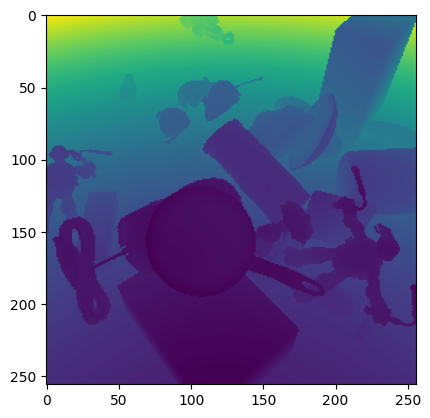

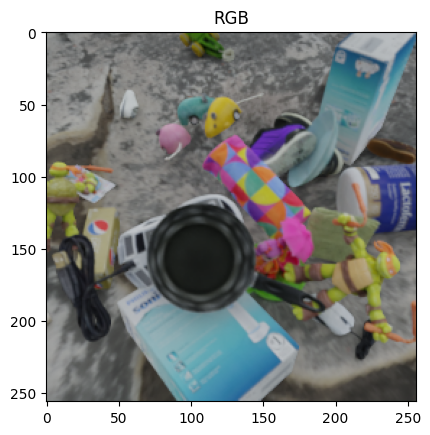

tensor(0, dtype=torch.int32) tensor(1, dtype=torch.int32)


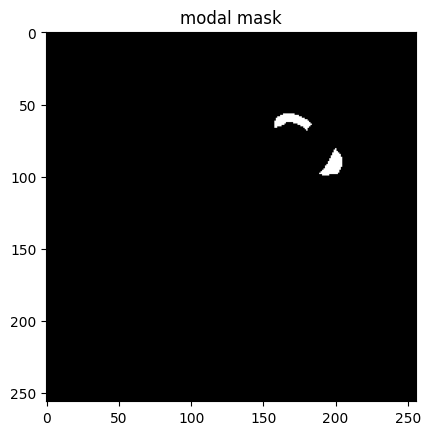

tensor(0.) tensor(1.)


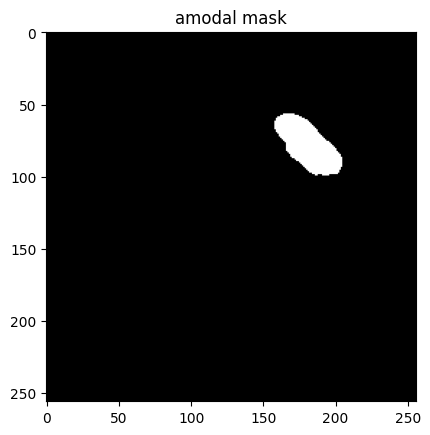

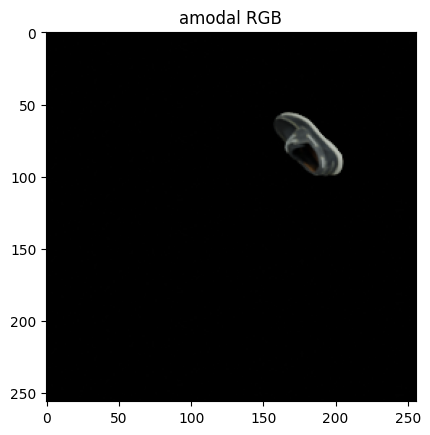

In [ ]:

dep = sample['depths'][0][0]
print(dep.min(), dep.max())
plt.imshow(dep)
plt.show()

rgb = sample['frames'][:, 0].permute(1,2,0)
plt.imshow(rgb)
plt.title("RGB")
plt.show()

mmask = sample['modal_masks'][:, 0].permute(1,2,0)
print(mmask.min(), mmask.max())
plt.imshow(mmask, cmap='gray')
plt.title("modal mask")
plt.show()

amask = sample['amodal_masks'][:, 0].permute(1,2,0)
print(amask.min(), amask.max())
plt.imshow(amask, cmap='gray')
plt.title("amodal mask")
plt.show()

plt.imshow(sample['amodal_content'][:, 0].permute(1,2,0))
plt.title("amodal RGB")
plt.show()

tensor(5.8166) tensor(18.2310)
tensor(0, dtype=torch.int32) tensor(1, dtype=torch.int32)
tensor(0.) tensor(1.)


(<Figure size 600x900 with 6 Axes>,
 array([[<Axes: title={'center': 'RGB'}>,
         <Axes: title={'center': 'depths'}>],
        [<Axes: title={'center': 'modal mask'}>,
         <Axes: title={'center': 'modal RGB'}>],
        [<Axes: title={'center': 'amodal mask'}>,
         <Axes: title={'center': 'amodal RGB'}>]], dtype=object))

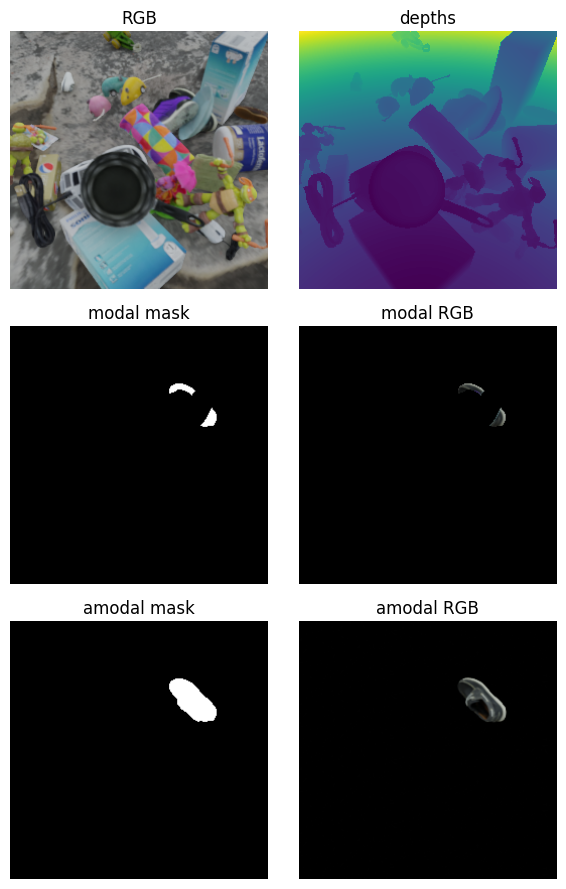

In [23]:
plot_img_sample(sample)